Goal: identify the sales and traffic per hour for the following month

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


#### <CENTER> READING DATASETS </CENTER>

##### DATASET DESCRIPTION

> **training_sales.csv** contains hourly sales of a store in the US. 

        - Date: Date Time of the Sales
        - Value: Sales in cents

> **training_traffic.csv** contains hourly traffic of the same store in the US.

        - Date: Date Time of the Traffic
        - Value: Traffic data in person measured using store sensors



In [2]:
#Reading Datasets
sales_df = pd.read_csv("training_Sales.csv")
traffic_df = pd.read_csv("training_Traffic.csv")

### <CENTER> Data Preparation and Exploration </CENTER>

**This Section will focus on the following:** </br>
    - Cleaning the data by (Removing nulls and outliers where necessary)</br>
    - Finding (patterns/correlation) in the data</br>
    - descriptive statistics </br>
    - Other useful analytics

In [3]:
sales_df.head(5) #Showing the first 5 Datapoints

,Date,Value
0,2013-11-07 13:00:00,830
1,2013-11-07 13:15:00,885
2,2013-11-07 13:30:00,938
3,2013-11-07 13:45:00,804
4,2013-11-07 14:00:00,793


In [4]:
traffic_df.head(5)#Showing the first 5 Datapoints

,Date,Value
0,2015-01-01 10:00:00,0
1,2015-01-01 10:15:00,1
2,2015-01-01 10:30:00,4
3,2015-01-01 10:45:00,3
4,2015-01-01 11:00:00,1


Finding information about the DataFrames including the index dtype and columns, non-null values and memory usage.

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67058 entries, 0 to 67057
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    67058 non-null  object
 1   Value   67058 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [6]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58437 entries, 0 to 58436
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    58437 non-null  object
 1   Value   58437 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 913.2+ KB


-   **Converting intervals**

    - Before cleaning the datasets, i converted the timestamps to intervals of _60 minutes/an hour_ to make it easier for the analysis as the main goal of this exercise is to identify the sales and traffic of the store for the next hour.


-  **Diagnostics**

    - _Null/Missing Values_
        - The Original Data doesn't seem to have null values from the results obtained, but that doesn't make me to conclude that there are no null/missing values. Because the main goal of this dataset is to forecast traffic and Sales for the next hour, some hours have nulls after resampling the data using an hour interval as there are times where the store may not have sales for an hour and other null values represent when the store was closed. 
        

    -  _Outliers_
        - I used scatter to highlight obvious inconsistencies that could indicate that the value was entered incorrectly because it differed from the other data points in the datasets. The traffic values do not appear to be outliers. for sales in the original dataset, the store's sales in 2017-07-09 19:15:00, as sales typically range from $0 -3000$, and $>6000=6435$ appears to be an outlier when compared to other points.  </br>

- **Remedies**

    - _Null/Missing Values_ 
        - The dataset is a time series, we considered the business hours of the United States, and adding a day of the week column in the data will help to identify the times when the store was closed and when the store was not making sales, because removing all the Null values implies that the store does not experience hours where there are no sales, which is likely false. Removing the hours when the store is closed may appear to be removing information, but domain knowledge also aids in data exploration. Furthermore, the missing values during operating hours can be treated as a case of Missing at Random (MNAR) whilst the ones where the store was not operating, setting them to zero is illogical because it will be assumed that their store did not make any sales/did not have customers while it was closed. [6] provides the following information about business hours in the United States:</br>
        
           > **Shopping Malls**
            - Monday-Saturday: 10 a.m.-9 p.m.</br>
            - Sunday: 11 a.m.-6 p.m. </br>

           > **Supermarkets**
            - Daily: 8 a.m.-8 p.m.</br>
            - Some open 24 hours
        

    - _Outliers_
        -  The outlier from the original dataset was automatically adjusted after the intervals were converted from 15 minutes to an hour, and it is no longer an outlier. This clearly indicates that the data point was an outlier in the 15-minute interval; it is possible that the store made a lot of sales on July 9, 2017 between 19:15:00 and 19:15:00.Figures below show the scatter plot before and after conversion..</br>

#### Missing Values and converting the time intervals

In [7]:
#Changing the data types of the dates to date data type from being objects
sales_df["Date"]= pd.to_datetime(sales_df["Date"],errors='coerce', infer_datetime_format=True)
traffic_df["Date"] = pd.to_datetime(traffic_df["Date"],errors='coerce', infer_datetime_format=True)

#Creating datasets I will use throughout (Avoiding to edit the origianl dataset)
sales_mod_df = sales_df.copy()
traffic_mod_df = traffic_df.copy()

In [8]:
#Resampling
sales_mod_df = sales_mod_df.resample('H', on="Date").sum(min_count=1).reset_index()
traffic_mod_df = traffic_mod_df.resample('H', on="Date").sum(min_count=1).reset_index()

##### Handling the Missing/Null Values

In [9]:
#Removing hours where the store doesn't open
sales_mod_df["weekday"] = sales_mod_df.Date.dt.day_name()
traffic_mod_df["weekday"] = traffic_mod_df.Date.dt.day_name()

#Will Check for Saturday, Sunday and Monday for both dataset
sales_saturdays_times = sales_mod_df[sales_mod_df["weekday"]=="Saturday"]
sales_sundays_times = sales_mod_df[sales_mod_df["weekday"]=="Sunday"]
sales_monday_times = sales_mod_df[sales_mod_df["weekday"]=="Monday"]

#Will Check for Saturday, Sunday and Monday for both dataset
traffic_saturdays_times = traffic_mod_df[traffic_mod_df["weekday"]=="Saturday"]
traffic_sundays_times = traffic_mod_df[traffic_mod_df["weekday"]=="Sunday"]
traffic_monday_times = traffic_mod_df[traffic_mod_df["weekday"]=="Monday"]

#Monday to Friday times: 8am to 10pm (Sales starts around 10am but the traffic starts at 8 am till 10pm)
sales_monday_times.head(60) # or Tail
traffic_monday_times.head(60) # or Tail

#Saturday Times: 9am to 10pm (Sales starts around 10am but the traffic starts at 9 am till 10pm)
sales_saturdays_times.head(60) # or Tail
traffic_saturdays_times.head(60) # or Tail

#Sunday Times: 10 am to 7pm (Sales starts around 10am but the traffic starts at 9 am till 10pm)
sales_monday_times.head(60) # or Tail
sales_sundays_times.head(60) # or Tail

#Removing the times where the store was not operating

sales_mod_df= sales_mod_df[((sales_mod_df["Date"].dt.hour<=22)&(sales_mod_df["Date"].dt.hour>=8))] #Weekdays
sales_mod_df= sales_mod_df.drop(sales_mod_df[(sales_mod_df["Date"].dt.hour==8) & (sales_mod_df["weekday"]=="Saturday")].index)#Saturday
sales_mod_df= sales_mod_df.drop(sales_mod_df[(sales_mod_df["Date"].dt.hour==8) & (sales_mod_df["weekday"]=="Sunday")].index)#Sundays
sales_mod_df= sales_mod_df.drop(sales_mod_df[(sales_mod_df["Date"].dt.hour==9) & (sales_mod_df["weekday"]=="Sunday")].index)#Sundays
sales_mod_df= sales_mod_df.drop(sales_mod_df[(sales_mod_df["Date"].dt.hour>=20) & (sales_mod_df["weekday"]=="Sunday")].index)#Sundays

traffic_mod_df= traffic_mod_df[((traffic_mod_df["Date"].dt.hour<=22)&(traffic_mod_df["Date"].dt.hour>=8))] #Weekdays
traffic_mod_df= traffic_mod_df.drop(traffic_mod_df[(traffic_mod_df["Date"].dt.hour==8) & (traffic_mod_df["weekday"]=="Saturday")].index)#Saturday
traffic_mod_df= traffic_mod_df.drop(traffic_mod_df[(traffic_mod_df["Date"].dt.hour==8) & (traffic_mod_df["weekday"]=="Sunday")].index)#Sundays
traffic_mod_df= traffic_mod_df.drop(traffic_mod_df[(traffic_mod_df["Date"].dt.hour==9) & (traffic_mod_df["weekday"]=="Sunday")].index)#Sundays
traffic_mod_df= traffic_mod_df.drop(traffic_mod_df[(traffic_mod_df["Date"].dt.hour>=20) & (traffic_mod_df["weekday"]=="Sunday")].index)#Sundays


Showing The Dataframes where the store operating times are fixed to business hours for each day </br>
**Note**: The Nan represent where the store did not make sales which will be update to Zero in the preeceding step and the exra weekday columns represents the day of which the store was operating

In [10]:
sales_mod_df.head(10)

,Date,Value,weekday
0,2013-11-07 13:00:00,3457.0,Thursday
1,2013-11-07 14:00:00,2250.0,Thursday
2,2013-11-07 15:00:00,NaN,Thursday
3,2013-11-07 16:00:00,729.0,Thursday
4,2013-11-07 17:00:00,NaN,Thursday
5,2013-11-07 18:00:00,1633.0,Thursday
6,2013-11-07 19:00:00,NaN,Thursday
7,2013-11-07 20:00:00,756.0,Thursday
8,2013-11-07 21:00:00,NaN,Thursday
9,2013-11-07 22:00:00,NaN,Thursday


In [11]:
traffic_mod_df.head(10)

,Date,Value,weekday
0,2015-01-01 10:00:00,8.0,Thursday
1,2015-01-01 11:00:00,14.0,Thursday
2,2015-01-01 12:00:00,28.0,Thursday
3,2015-01-01 13:00:00,33.0,Thursday
4,2015-01-01 14:00:00,47.0,Thursday
5,2015-01-01 15:00:00,49.0,Thursday
6,2015-01-01 16:00:00,48.0,Thursday
7,2015-01-01 17:00:00,43.0,Thursday
8,2015-01-01 18:00:00,28.0,Thursday
9,2015-01-01 19:00:00,2.0,Thursday


##### Removing the extra columns added and Replacing Null Values with Zero (0) as it represent times where the store did not make asales or where the store did not count nmber of people in-store

In [12]:
#Filling thr Null values
traffic_mod_df.fillna(0,inplace=True)
sales_mod_df.fillna(0,inplace=True)

#Removing the extra columns added
traffic_mod_df.drop(columns=["weekday"], inplace=True)
sales_mod_df.drop(columns=["weekday"], inplace=True)

Spotting Ouliers in the datasets using scatter plot

**Notice:** That there was an outlier in the 15 mins intervals in the sales but after performing the conversion of the intervals to an hours, it shows that there is no oulier.

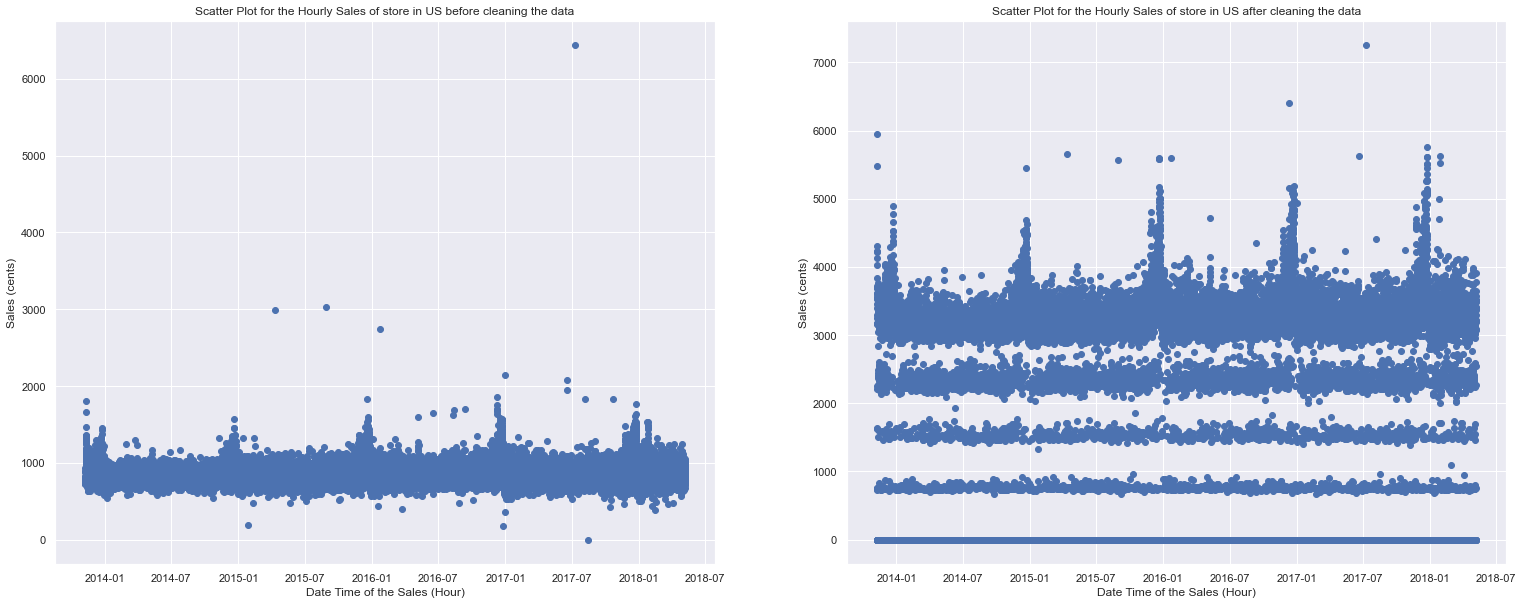

In [13]:
#Sales 

figure, (old_sales, new_sales) =plt.subplots(ncols=2, nrows=1, figsize=((26,10)))

old_sales.scatter(x=sales_df["Date"], y=sales_df["Value"])
old_sales.set_title("Scatter Plot for the Hourly Sales of store in US before cleaning the data")
old_sales.set_xlabel("Date Time of the Sales (Hour)")
old_sales.set_ylabel("Sales (cents)")

new_sales.scatter(x=sales_mod_df["Date"], y=sales_mod_df["Value"])
new_sales.set_title("Scatter Plot for the Hourly Sales of store in US after cleaning the data")
new_sales.set_xlabel("Date Time of the Sales (Hour)")
new_sales.set_ylabel("Sales (cents)")

plt.show()

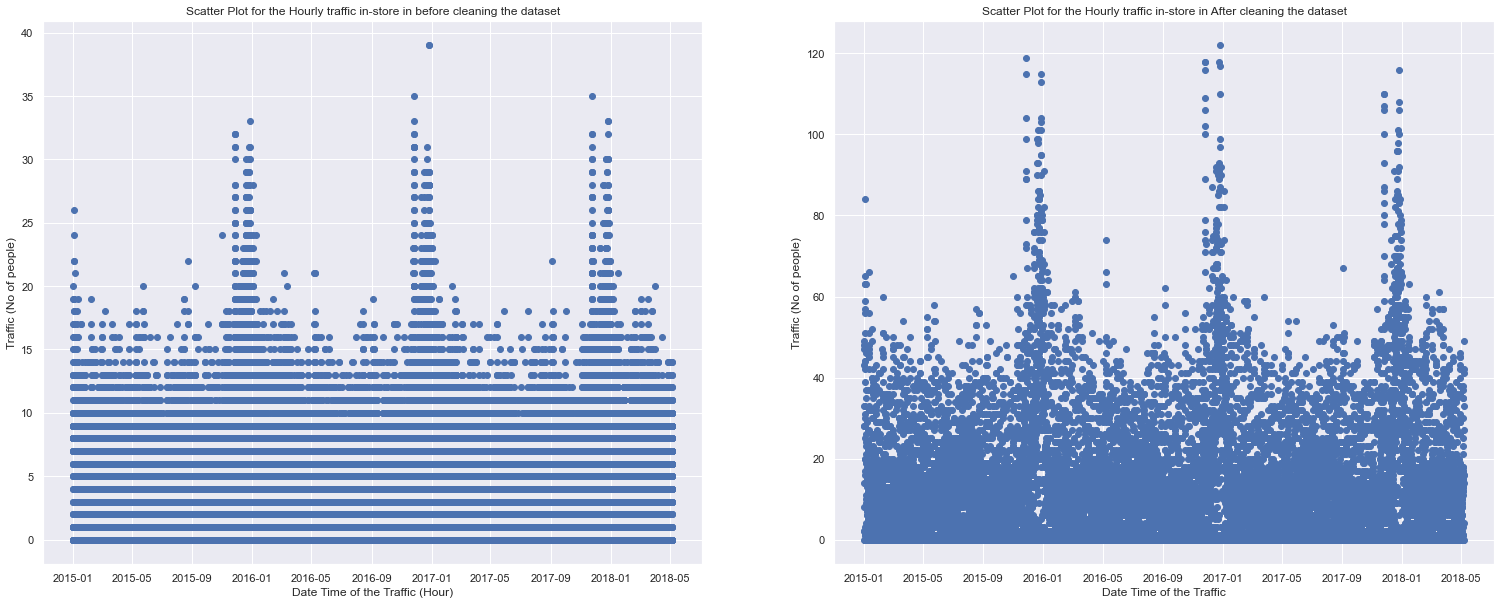

In [14]:
#Traffic

figure, (old_traffic, new_traffic) =plt.subplots(ncols=2, nrows=1, figsize=((26,10)))

old_traffic.scatter(x=traffic_df["Date"], y=traffic_df["Value"])
old_traffic.set_title("Scatter Plot for the Hourly traffic in-store in before cleaning the dataset")
old_traffic.set_xlabel("Date Time of the Traffic (Hour)")
old_traffic.set_ylabel("Traffic (No of people)")

new_traffic.scatter(x=traffic_mod_df["Date"], y=traffic_mod_df["Value"])
new_traffic.set_title("Scatter Plot for the Hourly traffic in-store in After cleaning the dataset")
new_traffic.set_xlabel("Date Time of the Traffic")
new_traffic.set_ylabel("Traffic (No of people)")

plt.show()


**Imputing Missing Data points bt MCR (Missing Completely Random)** </br>
The datasets are not equal in terms of the number of data points; the traffic dataset has $17278$ data points, while the sales dataset has $23215$ data points; the difference between the two is approximately $25\%$ of data points, so it is reasonable not to remove so much data. There are several approaches I could take to make these two equals. Removing data that is not common on the datasets but removing these data points will result in the loss of important information about the dataset because this data is a time series. Because the data is missing from 2013-Nov-2013 to 2015-01-01, keep in mind that these datasets are Time Series, so such information will not be useful when modelling with other supervised algorithms. I will impute the data using an average because it makes more sense to impute using an average in a time series dataset.

**Note**: The Average size must be suitable for this problem. It would not make sense to calculate the annual average traffic for the store as it is a huge sample to estimate the actual traffic. 

In [15]:
#renaming the Value columns differently to avoid dupplication
sales_mod_df.rename(columns={"Value":"sales_value"}, inplace=True)
traffic_mod_df.rename(columns= {"Value":"traffic_value"}, inplace=True)

In [16]:
#hourly averages for traffic

traffic_average_df = traffic_mod_df.copy() #to be use for computing the averages to be used to impute missing Values

traffic_average_df['hour'] = traffic_average_df['Date'].dt.hour  #Adding the month column to usedc for groupingBy
traffic_average_df.drop(columns=["Date"], inplace=True)
grouped_by_hour = np.round(traffic_average_df.groupby("hour").mean()).astype(int) #Making the average an integer for it to correspond with the other ones

In [17]:
#Combining the datasets to fix the missing data points

combined_df = sales_mod_df.merge(traffic_mod_df, on="Date",how="left")
for hour in range(8,23,1):
    combined_df["traffic_value"]= np.where((combined_df["traffic_value"].isnull()) & (combined_df["Date"].dt.hour==hour) , grouped_by_hour.loc[hour][0],combined_df["traffic_value"])

combined_df["traffic_value"] = combined_df["traffic_value"].astype(int) #Converting the data type of the calculated average to int 

In [18]:
#Storing it in a new variable so we can compare which data the model is robust on
sales_mod_df_joined = combined_df[["Date","sales_value"]]
traffic_mod_df_joined = combined_df[["Date","traffic_value"]]

#renaming the column to the same name as the original datasets
sales_mod_df_joined.rename(columns={"sales_value":"Value"}, inplace=True)
traffic_mod_df_joined.rename(columns= {"traffic_value":"Value"}, inplace=True)

#Renaming the columns name to their original names
sales_mod_df.rename(columns={"sales_value":"Value"}, inplace=True)
traffic_mod_df.rename(columns={"traffic_value":"Value"}, inplace=True)

In [19]:
sales_mod_df_joined #Displaying the modefied dataset

,Date,Value
0,2013-11-07 13:00:00,3457.0
1,2013-11-07 14:00:00,2250.0
2,2013-11-07 15:00:00,0.0
3,2013-11-07 16:00:00,729.0
4,2013-11-07 17:00:00,0.0
...,...,...
23210,2018-05-06 15:00:00,3645.0
23211,2018-05-06 16:00:00,3372.0
23212,2018-05-06 17:00:00,3077.0
23213,2018-05-06 18:00:00,3190.0


In [20]:
traffic_mod_df_joined #Displaying the modefied dataset

,Date,Value
0,2013-11-07 13:00:00,24
1,2013-11-07 14:00:00,25
2,2013-11-07 15:00:00,25
3,2013-11-07 16:00:00,23
4,2013-11-07 17:00:00,19
...,...,...
23210,2018-05-06 15:00:00,41
23211,2018-05-06 16:00:00,33
23212,2018-05-06 17:00:00,27
23213,2018-05-06 18:00:00,14


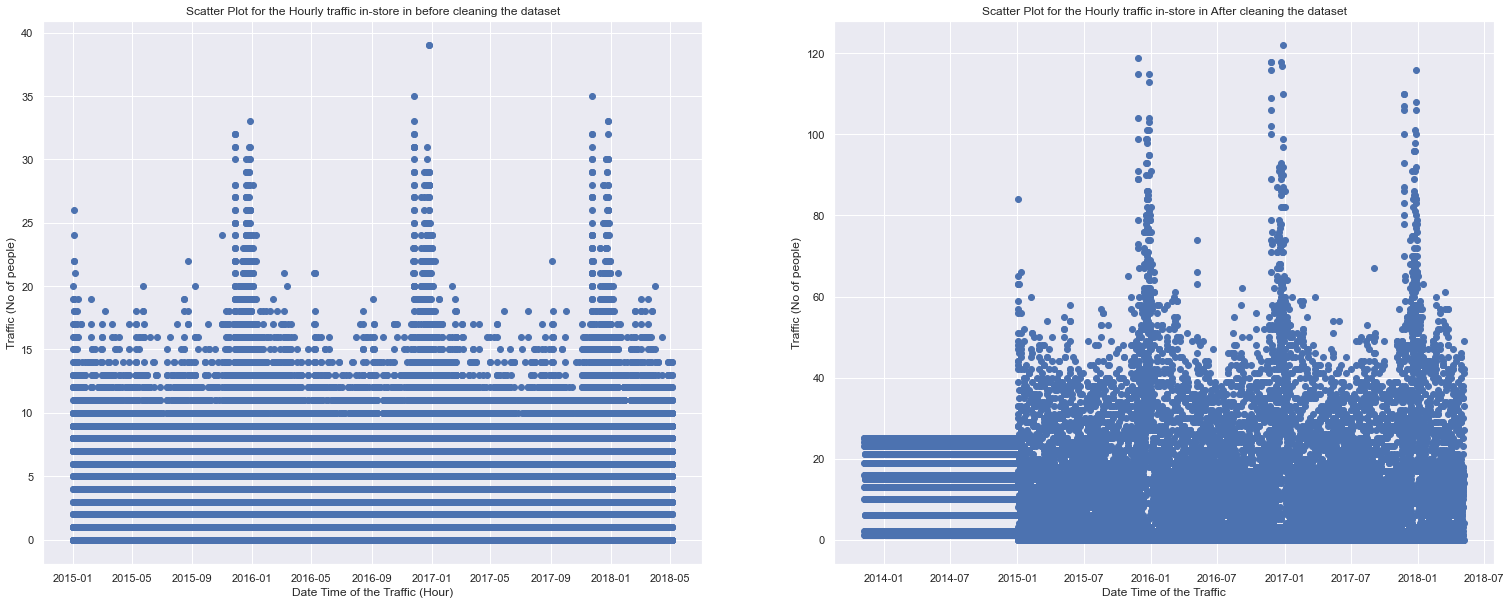

In [21]:
#Traffic dataset after adding the years not present (No change in the sales dataset)

figure, (old_traffic, new_traffic) =plt.subplots(ncols=2, nrows=1, figsize=((26,10)))

old_traffic.scatter(x=traffic_df["Date"], y=traffic_df["Value"])
old_traffic.set_title("Scatter Plot for the Hourly traffic in-store in before cleaning the dataset")
old_traffic.set_xlabel("Date Time of the Traffic (Hour)")
old_traffic.set_ylabel("Traffic (No of people)")

new_traffic.scatter(x=traffic_mod_df_joined["Date"], y=traffic_mod_df_joined["Value"])
new_traffic.set_title("Scatter Plot for the Hourly traffic in-store in After cleaning the dataset")
new_traffic.set_xlabel("Date Time of the Traffic")
new_traffic.set_ylabel("Traffic (No of people)")

plt.show()

#### Descriptive statistics and Distributions for the Original Dataset and the Joined Datasets

- Descriptive statistics give me the measures of central tendency, a summary metric that attempts to describe an entire set of data with a single value representing the middle or centre of its distribution. In addition, this descriptive shows an overall mean of the dataset whether it is trending or not and the mean and the standard deviation of the traffic edited dataset are close which gives us an idea that the edited dataset might have similar metrics to the original dataset. By this, we can continue using the original dataset despite the fact that they are not equal. 

In [22]:
sales_mod_df.describe().T #Descriptive statistics for the sales (Recall that sales was not changed)

,count,mean,std,min,25%,50%,75%,max
Value,23215.0,2344.724316,1344.493665,0.0,1487.0,3061.0,3262.0,7249.0


In [23]:
traffic_mod_df.describe().T #Original Trattic dataset (Only intervals changed)

,count,mean,std,min,25%,50%,75%,max
Value,17278.0,14.151406,15.079562,0.0,3.0,10.0,19.0,122.0


In [24]:
traffic_mod_df_joined.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,23215.0,14.1437,13.762053,0.0,3.0,12.0,21.0,122.0


**Analysis to observe the pattern in the week**

- plotting the hours and sales for each day of the week

- Plotting the hours and traffic for each day of the week

From the two plots below, It is clear that the store is usually busy on weekends _(Friday, Saturday and Sunday)_ which makes sense because during the week people might be busy with their occupations. What is interesting from these plots is that the store opens for few hours on sunday buy it tends to have traffic and makes more slaes as comoared to the weekdays sales. 

In [25]:
#Copying the Dataframes for Plots
plotting_sales = sales_mod_df.copy()
plotting_traffic=  traffic_mod_df.copy() 

plotting_sales["weekday"] = sales_mod_df.Date.dt.day_name()
plotting_traffic["weekday"] = traffic_mod_df.Date.dt.day_name()

plotting_sales["hour"] = sales_mod_df.Date.dt.hour
plotting_traffic["hour"] = traffic_mod_df.Date.dt.hour

plotting_sales.drop(columns=["Date"], inplace=True)
plotting_traffic.drop(columns=["Date"], inplace=True)

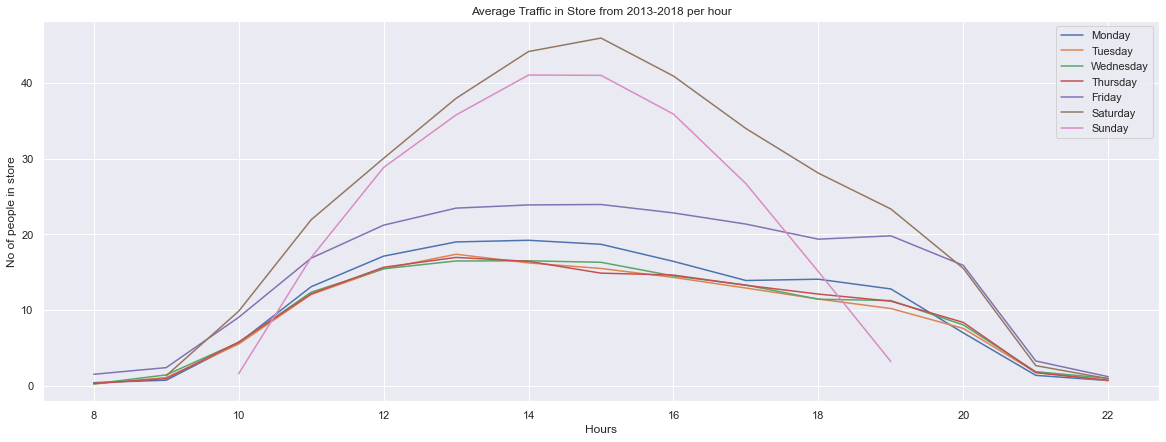

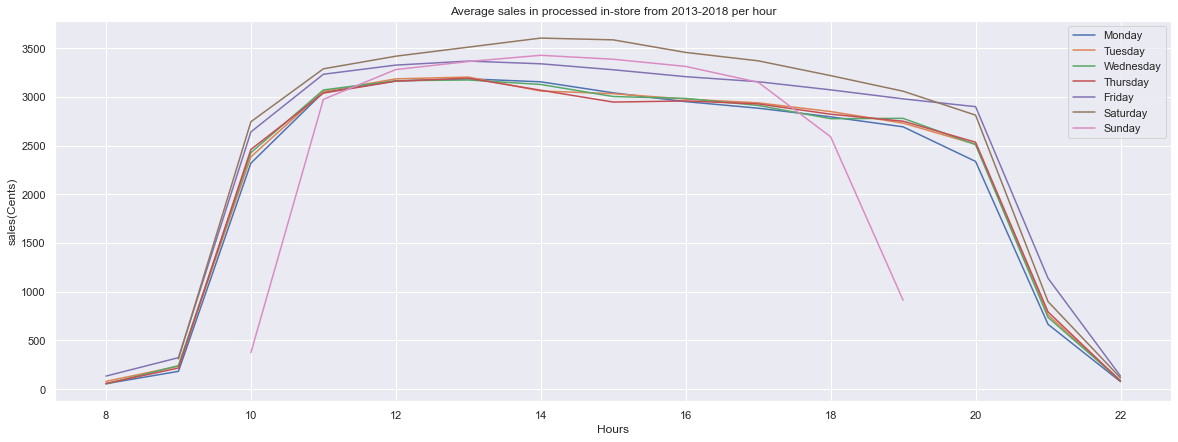

In [26]:
def plot(dataframe, title,y_axis):

    grouped_1 = dataframe.groupby(["hour","weekday"]).mean().reset_index()

    grouped_1_monday = grouped_1[grouped_1["weekday"]=="Monday"]
    grouped_1_Tuesday = grouped_1[grouped_1["weekday"]=="Tuesday"]
    grouped_1_Wednesday = grouped_1[grouped_1["weekday"]=="Wednesday"]
    grouped_1_Thurday = grouped_1[grouped_1["weekday"]=="Thursday"]
    grouped_1_Friday = grouped_1[grouped_1["weekday"]=="Friday"]
    grouped_1_Saturday = grouped_1[grouped_1["weekday"]=="Saturday"]
    grouped_1_Sunday = grouped_1[grouped_1["weekday"]=="Sunday"]



    plt.figure(figsize=(20, 7))
    plt.plot(grouped_1_monday["hour"],grouped_1_monday["Value"], label="Monday")
    plt.plot(grouped_1_Tuesday["hour"],grouped_1_Tuesday["Value"], label="Tuesday")
    plt.plot(grouped_1_Wednesday["hour"],grouped_1_Wednesday["Value"], label="Wednesday")
    plt.plot(grouped_1_Thurday["hour"],grouped_1_Thurday["Value"], label="Thursday")
    plt.plot(grouped_1_Friday["hour"],grouped_1_Friday["Value"], label="Friday")
    plt.plot(grouped_1_Saturday["hour"],grouped_1_Saturday["Value"], label="Saturday")
    plt.plot(grouped_1_Sunday["hour"],grouped_1_Sunday["Value"], label="Sunday")


    plt.title(title)
    plt.xlabel("Hours")
    plt.ylabel(y_axis)
    plt.legend()
    plt.show()

#Plot 1
hour_week_value_traffic = plotting_traffic[["hour","weekday","Value"]]
title_1 = "Average Traffic in Store from 2013-2018 per hour"
y_axis_1 = "No of people in store"
plot(dataframe=hour_week_value_traffic, title=title_1,y_axis=y_axis_1)

#Plot 2
hour_week_value_sales = plotting_sales[["hour","weekday","Value"]]
title_2 = "Average sales in processed in-store from 2013-2018 per hour"
y_axis_2 = "sales(Cents)"
plot(dataframe=hour_week_value_sales, title=title_2,y_axis=y_axis_2)


### <CENTER>Information that links the preparation and Modelling</CENTER>

Before computing the model, I plotted the data to observe whether the datasets show trends and seasonality.

The moving averages are based on the idea of windowing because the datasets are not too complex implementing the simple average for smoothing would work perfectly fine. in Addition, Simple Moving Average is computed by the following algorithm: each next value is the mean value of the previous 92 (week) observations. Recall that a Window length should be greater than the frequency of the time series which in this case is an hour, and is typically defined as a minute, hour, day, week, or month.

Recall each point represents an hour, my window for a month will not be 30/31 data points because the shop does not open 24 hours similarly for a week the window would not be 7 data points as the data point interval is an hour and the hours for each day are not equal. Just to recap, the shop opens 14 hours on weekdays, 13 Hours Saturdays, and 9 Hours Sundays. Each data point represents an hour. Thus, in this case, I will use an average for a week which implies that the window will be $(14 * 5 + 13 + 9 = 92) $ and for identification of the trend I will use a monthly average. 

Choosing a window size is often an iterative approach, choosing smaller windows will still smooth out the data, but not to the same extent whereas Choosing larger windows will result in a loss of too much information. Thus, A week is fine as a month will make me lose much information.

The plot shows the pattern of the sales dataset in the averaged plot as in the original plot it is hard to tell whether there is a pattern or not. Similarly, to the traffic dataset, It also shows a pattern where there is a peak annually (December-January). Interestingly, the plots further indicate an increase in sales as time goes by whilst the traffic remains constant which makes sense as there are inflations rate which causes the prices to go up in the store. on the other side, people keep buying goods from the store whether prices go up or not.

_More will be computed on the modelling part of the Notebook_


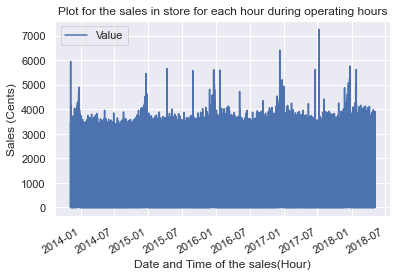

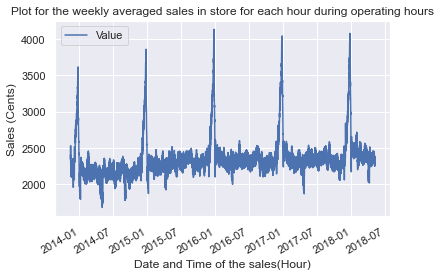

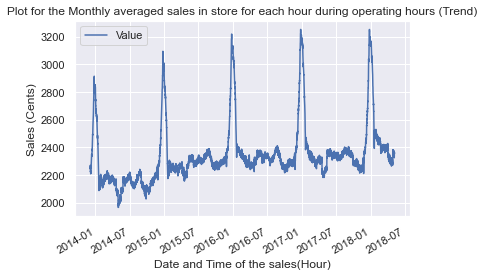

In [27]:
#Computing the smoothing average for both dataset
sales_mean = sales_mod_df.set_index("Date")
sales_mean_week = sales_mean.rolling(window=92).mean()
sales_mean_month = sales_mean.rolling(window=368).mean()

sales_mod_df.plot(x="Date", y="Value")
plt.title("Plot for the sales in store for each hour during operating hours")
plt.xlabel("Date and Time of the sales(Hour)")
plt.ylabel("Sales (Cents)")
plt.show()

sales_mean_week.plot()
plt.title("Plot for the weekly averaged sales in store for each hour during operating hours")
plt.xlabel("Date and Time of the sales(Hour)")
plt.ylabel("Sales (Cents)")


sales_mean_month.plot()
plt.title("Plot for the Monthly averaged sales in store for each hour during operating hours (Trend)")
plt.xlabel("Date and Time of the sales(Hour)")
plt.ylabel("Sales (Cents)")

plt.show()

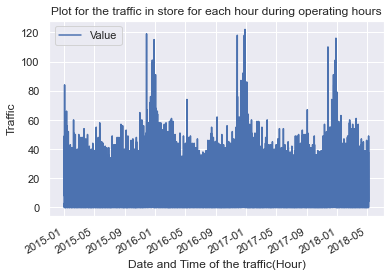

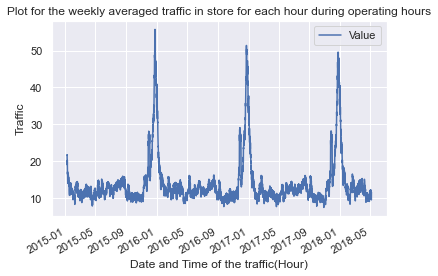

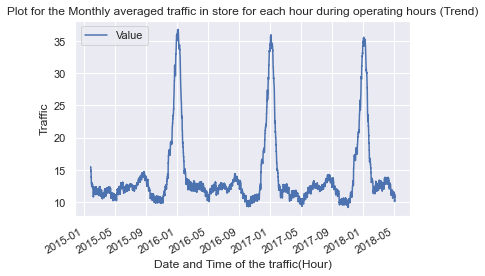

In [28]:
traffic_mean = traffic_mod_df.set_index("Date")
traffic_mean_week = traffic_mean.rolling(window=92).mean()
traffic_mean_month = traffic_mean.rolling(window=368).mean()


traffic_mod_df.plot(x="Date", y="Value")
plt.title("Plot for the traffic in store for each hour during operating hours")
plt.xlabel("Date and Time of the traffic(Hour)")
plt.ylabel("Traffic")
plt.show()

traffic_mean_week.plot()
plt.title("Plot for the weekly averaged traffic in store for each hour during operating hours")
plt.xlabel("Date and Time of the traffic(Hour)")
plt.ylabel("Traffic")
plt.show()


traffic_mean_month.plot() #For identifying a trend
plt.title("Plot for the Monthly averaged traffic in store for each hour during operating hours (Trend)")
plt.xlabel("Date and Time of the traffic(Hour)")
plt.ylabel("Traffic")
plt.show()

### <CENTER>Reduction of Explanatory Variable</CENTER>

In the previous section, I introduced the step of applying remedies to the exploratory variables after performing some diagnostics for missing data points and outliers. In this study, I only reduced the variables that were used to clean/analyze the data such as the hour, weekday and year for each data point. Thus, this phase of model building is not applicable in this study as the variables seem to be important.

### <CENTER> Model Building</CENTER>

The datasets on for this problem are time series, the model that i will implement is a regression model as the main goal is to forecast sales and traffic of the store. The normal linear regression will not be robust as the time series regression models as it treats date as vakues not dates. Thus in this project the model used to forecast the upcoming month sales and traffic is Auto Regressive Integrated moving average (ARIMA). ARIMA can be simply defined as a statistical analysis model that uses time series data to either better understand or predict future trends. For instance, an ARIMA model may attempt to forecast a company's earnings based on previous periods.

**Note** :The modeling part will focus more on the original dataset(not with added data points) and the other dataset will be use to compare the robustness of the model

_The process of building this model requires steps as shows previous in the exploration part that we must test whether the data is stationary and observe the tred._

- The Trend plots seem to show a slighlty trend in the datasets
- On the other other hand, The data seem to be partially stationary in both Datasets

In [29]:
#Making the dates an index as they must be an index when building an ARIMA model 

sales_mod_df.set_index("Date", inplace= True)
traffic_mod_df.set_index("Date", inplace=True)


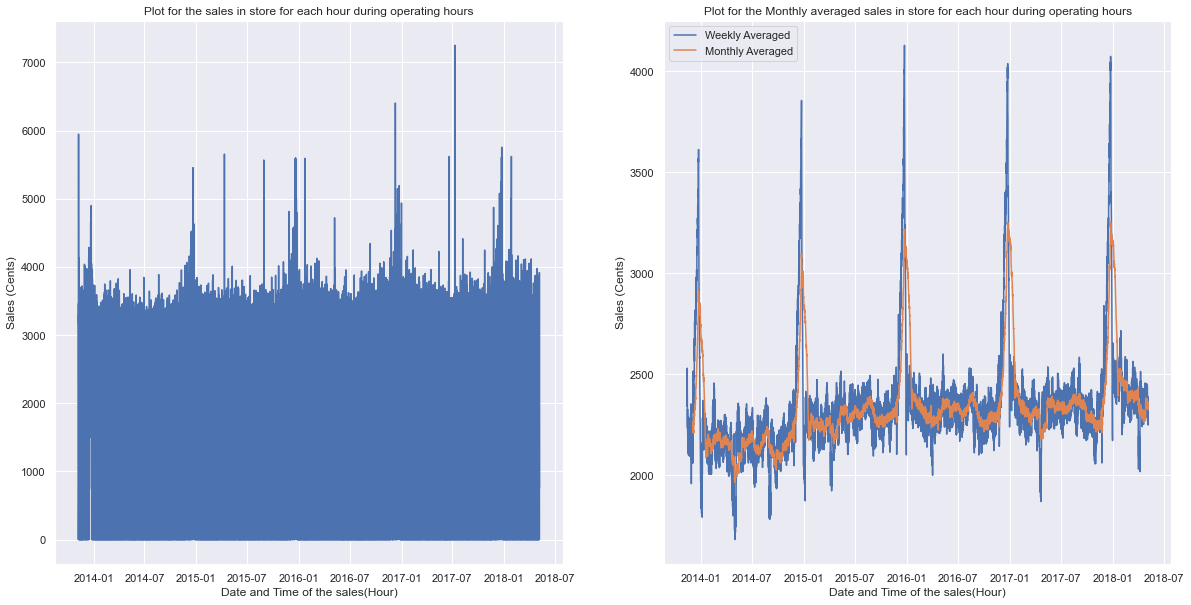

In [30]:
#Computing the smoothing average for both dataset

#As stated in the Exploration part with regards to the rolling window size
sales_mean_week = sales_mod_df.rolling(window=92).mean()
sales_mean_month = sales_mod_df.rolling(window=368).mean()


fig, (original, trends) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

original.plot(sales_mod_df)
original.set_title("Plot for the sales in store for each hour during operating hours")
original.set_xlabel("Date and Time of the sales(Hour)")
original.set_ylabel("Sales (Cents)")

trends.plot(sales_mean_week, label="Weekly Averaged")
trends.set_title("Plot for the weekly averaged sales in store for each hour during operating hours")
trends.set_xlabel("Date and Time of the sales(Hour)")
trends.set_ylabel("Sales (Cents)")

trends.plot(sales_mean_month, label="Monthly Averaged")
trends.set_title("Plot for the Monthly averaged sales in store for each hour during operating hours")
trends.set_xlabel("Date and Time of the sales(Hour)")
trends.set_ylabel("Sales (Cents)")

plt.legend()
plt.show()

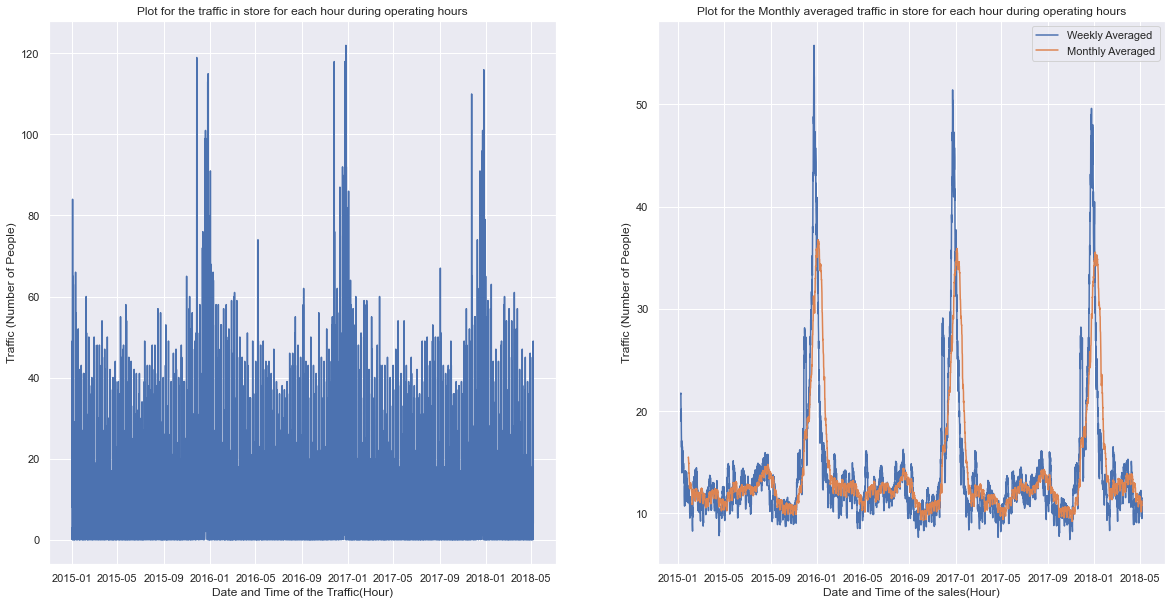

In [31]:
#Traffic dataset

traffic_mean_week = traffic_mod_df.rolling(window=92).mean()
traffic_mean_month = traffic_mod_df.rolling(window=368).mean()


fig, (original, trends) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

original.plot(traffic_mod_df)
original.set_title("Plot for the traffic in store for each hour during operating hours")
original.set_xlabel("Date and Time of the Traffic(Hour)")
original.set_ylabel("Traffic (Number of People)")

trends.plot(traffic_mean_week, label="Weekly Averaged")
trends.set_title("Plot for the weekly averaged traffic in store for each hour during operating hours")
trends.set_xlabel("Date and Time of the sales(Hour)")
trends.set_ylabel("Traffic (Number of People)")

trends.plot(traffic_mean_month, label="Monthly Averaged")
trends.set_title("Plot for the Monthly averaged traffic in store for each hour during operating hours")
trends.set_xlabel("Date and Time of the sales(Hour)")
trends.set_ylabel("Traffic (Number of People)")

plt.legend()
plt.show()

The monthly rolling window seems to show the trend well when compared to the weekly rolling window, but that does not mean I can use the monthly as it is very broad and using it won't help to forecast the sales and traffic as the plot shows that it does not spike closer to the actual value.</br>

_Plotitting the rolling Mean and the rolling Standard deviation of the dataset to test for Stationarity_


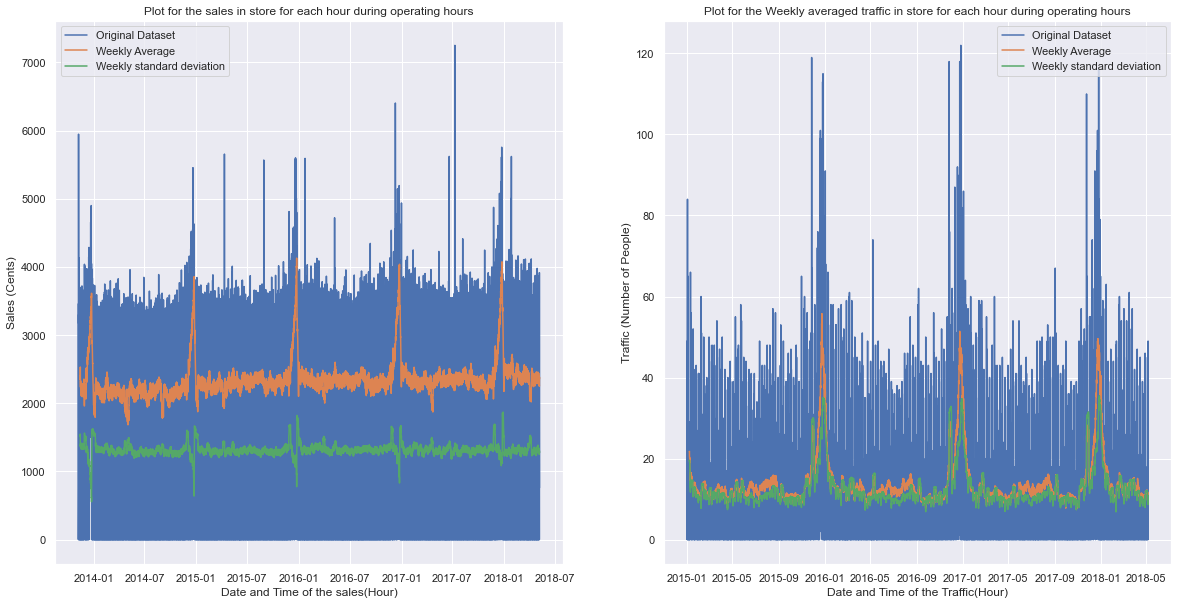

In [32]:
#Focus on the monthly rolling window as it di

#Computing only the standard deviations, means were computed
sales_standard_deviation = sales_mod_df.rolling(window=92).std()
traffic_standard_deviation = traffic_mod_df.rolling(window=92).std()

fig, (sales,traffic) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales.plot(sales_mod_df, label= "Original Dataset")
sales.plot(sales_mean_week, label= "Weekly Average")
sales.plot(sales_standard_deviation, label="Weekly standard deviation")
sales.set_title("Plot for the sales in store for each hour during operating hours")
sales.set_xlabel("Date and Time of the sales(Hour)")
sales.set_ylabel("Sales (Cents)")
sales.legend()

traffic.plot(traffic_mod_df, label= "Original Dataset")
traffic.plot(traffic_mean_week, label= "Weekly Average")
traffic.plot(traffic_standard_deviation, label="Weekly standard deviation")
traffic.set_title("Plot for the Weekly averaged traffic in store for each hour during operating hours")
traffic.set_xlabel("Date and Time of the Traffic(Hour)")
traffic.set_ylabel("Traffic (Number of People)")
traffic.legend()

plt.show()

**Testing for stationarity using Augmented Dickey–Fuller test** </br>
Note: I Used a significance level of 1% 

p-value > $0.05$: Fail to reject the null hypothesis, the data has a unit root and is non-stationary. </br>
p-value <= $0.05$: Reject the null hypothesis, the data does not have a unit root and is stationary. </br>

The results indicate that the sales datasets are stationary.

In [33]:
#Sales
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_mod_df)
print('ADF Statistic for Sales: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
        print(f'   {key} : {value}')
        print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

ADF Statistic for Sales: -16.897506
p-value: 0.000000
Critical Values:
   1% : -3.4306322869769432
Result: The series is stationary
   5% : -2.861664761862339
Result: The series is stationary
   10% : -2.56683640716699
Result: The series is stationary


In [34]:
#Traffic in store
result = adfuller(traffic_mod_df)
print('ADF Statistic for Traffic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
        print(f'   {key} : {value}')
        print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

ADF Statistic for Traffic: -12.933958
p-value: 0.000000
Critical Values:
   1% : -3.430729520357968
Result: The series is stationary
   5% : -2.8617077331762455
Result: The series is stationary
   10% : -2.5668592800441723
Result: The series is stationary


**Conclusion on Stationarity** </br>
As stated previously that the datasets seem to be slightly stationary.Indeed the Adf test shows that the two datasets are stationary. 


#### <center> Hyperparameters for the Model </center>

**Choosing a right order for the ARIMA Model using AIC and PAIC** 

- p = number of significant terms in PACF for trend

- d = Order of differencing for trend (In this case 0 because the data is stationary no need to difference it and the Optimal model from the Auto Arima shows that the optimal models does not have differencing)

- q= number of significant terms in ACF for trend

As it can be seen from the plots below that the AIC does not give us accurate results. I also used the Auto Arima to find a optimal order for each model

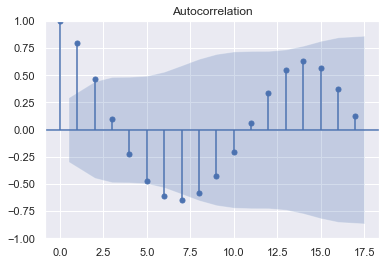

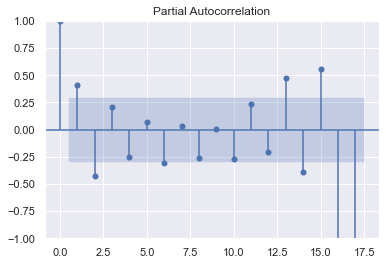

In [35]:
#ACF and PACF For Model order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf

sales_acf = acf(sales_mod_df)
sales_pacf = pacf(sales_mod_df)

a = plot_acf(sales_acf)
b= plot_pacf(sales_pacf)


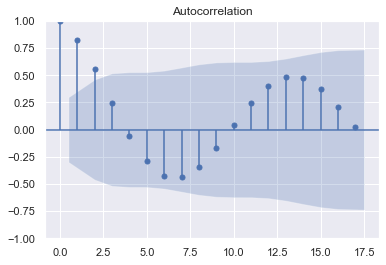

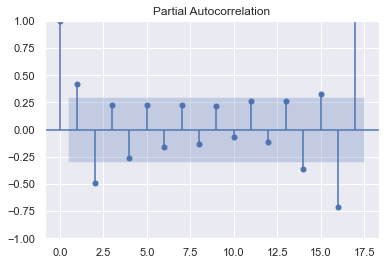

In [36]:
traffic_acf = acf(traffic_mod_df)
traffic_pacf = pacf(traffic_mod_df, method="ols")

a = plot_acf(traffic_acf)
b= plot_pacf(traffic_pacf)


In [37]:

from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

#Sales
model_sales = pm.auto_arima(sales_mod_df.Value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,            
                      d=None,  
                      seasonal=False, 
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_sales.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=386123.176, Time=1.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=432775.801, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=386540.153, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=411020.104, Time=3.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=386097.614, Time=2.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=386095.755, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=386097.318, Time=1.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=386073.222, Time=4.94 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=380016.701, Time=18.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=386008.073, Time=5.32 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=24.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=384109.546, Time=22.51 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=39.72 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 125.161 seconds
    

In [38]:
#Traffic
model_traffic = pm.auto_arima(traffic_mod_df.Value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_sales.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=117119.198, Time=2.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=153709.925, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=117853.123, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=137120.360, Time=1.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=116368.617, Time=6.79 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=116767.355, Time=1.32 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=116007.312, Time=4.99 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=116005.375, Time=1.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=114550.840, Time=2.59 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=115876.384, Time=3.48 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=114480.004, Time=11.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=114963.253, Time=11.83 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=112327.859, Time=25.84 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=114256.486, Time=11.62 sec
 

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequenc

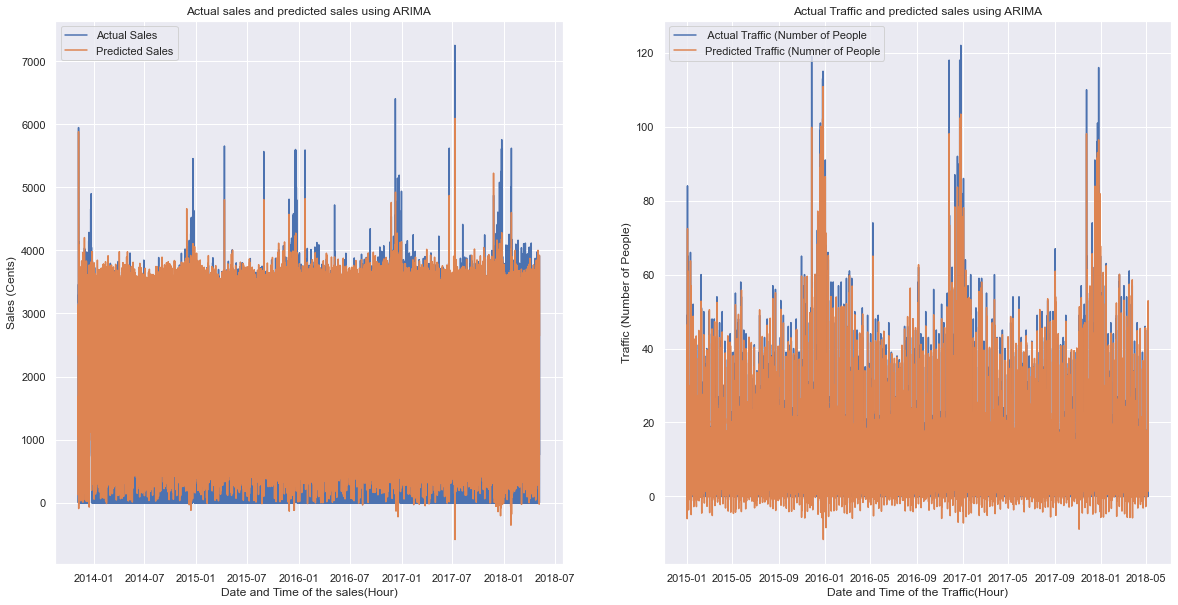

In [39]:
from statsmodels.tsa.arima.model import ARIMA

fig, (sales_plot,traffic_plot) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

#Sales
sales_model =ARIMA(sales_mod_df, order =(3,0,2))
sales_model_results = sales_model.fit()
sales_plot.plot(sales_mod_df, label="Actual Sales")
sales_plot.plot(sales_model_results.fittedvalues, label="Predicted Sales")
sales_plot.set_xlabel("Date and Time of the sales(Hour)")
sales_plot.set_ylabel("Sales (Cents)")
sales_plot.set_title("Actual sales and predicted sales using ARIMA")
sales_plot.legend()


#Traffic 
traffic_model =ARIMA(traffic_mod_df, order =(3,0,2))
traffic_model_results = traffic_model.fit()
traffic_plot.plot(traffic_mod_df, label=" Actual Traffic (Number of People")
traffic_plot.plot(traffic_model_results.fittedvalues, label="Predicted Traffic (Numner of People")
traffic_plot.set_xlabel("Date and Time of the Traffic(Hour)")
traffic_plot.set_ylabel("Traffic (Number of People)")
traffic_plot.set_title("Actual Traffic and predicted sales using ARIMA")
traffic_plot.legend()

plt.show()

####  Plotting The Actual Values and the Predicted for the two Datasets

- 2 Weeks from the initial data point

- Random Two Weeks in 

- Last Two weeks


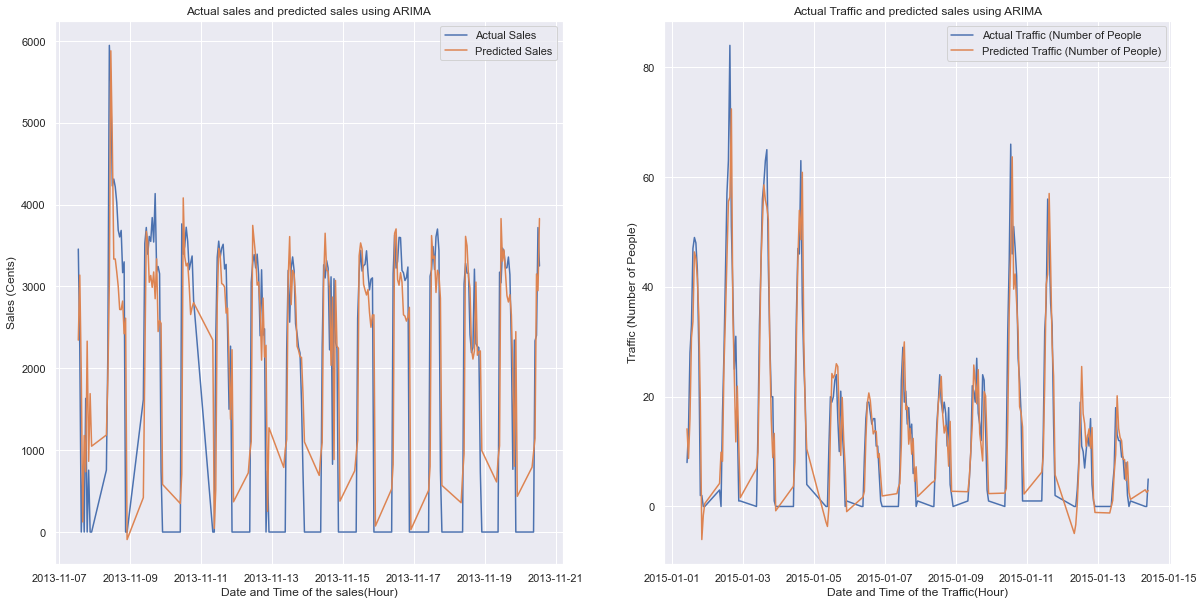

In [40]:
#Separating the dataframes 
# final_sales_df_predicted = final_sales_df[["predicted_value"]]
# final_traffic_df_predicted = final_traffic_df[["predicted_value"]]

forecasted_sales = sales_model_results.fittedvalues
forecasted_traffic = traffic_model_results.fittedvalues

fig, (sales_vs_plot,traffic_vs_plot) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

#Sales
sales_vs_plot.plot(sales_mod_df[:184], label="Actual Sales")
sales_vs_plot.plot(forecasted_sales[:184], label="Predicted Sales")
sales_vs_plot.set_xlabel("Date and Time of the sales(Hour)")
sales_vs_plot.set_ylabel("Sales (Cents)")
sales_vs_plot.set_title("Actual sales and predicted sales using ARIMA")
sales_vs_plot.legend()

#Traffic 
traffic_vs_plot.plot(traffic_mod_df[:184], label="Actual Traffic (Number of People")
traffic_vs_plot.plot(forecasted_traffic[:184], label="Predicted Traffic (Number of People)")
traffic_vs_plot.set_xlabel("Date and Time of the Traffic(Hour)")
traffic_vs_plot.set_ylabel("Traffic (Number of People)")
traffic_vs_plot.set_title("Actual Traffic and predicted sales using ARIMA")
traffic_vs_plot.legend()

plt.show()

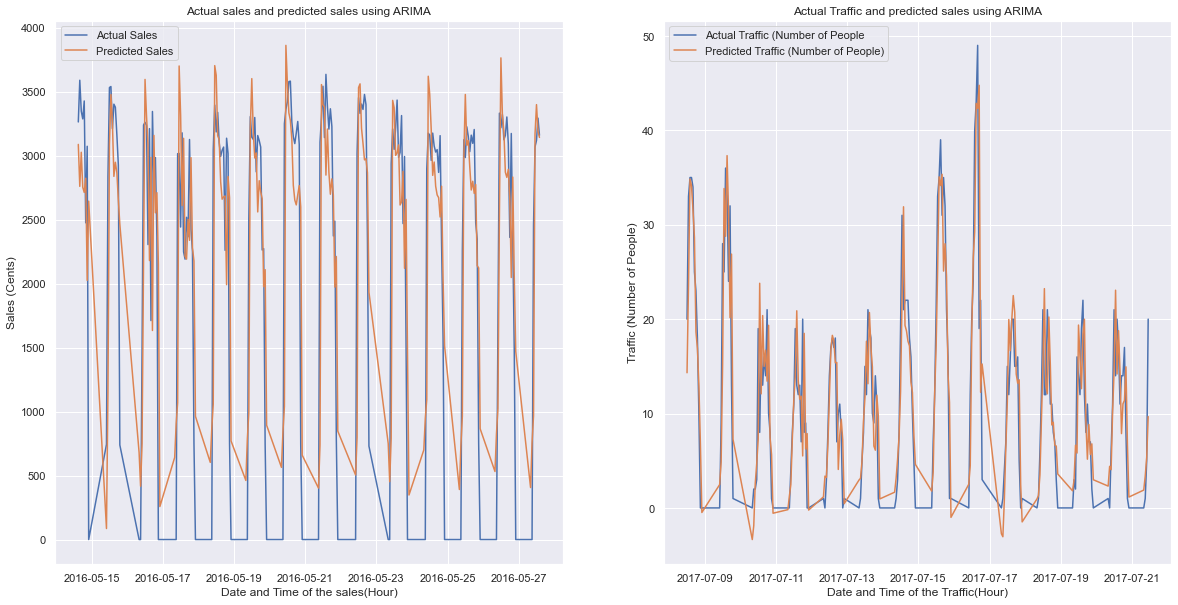

In [41]:
#Separating the dataframes 

fig, (sales_vs_plot,traffic_vs_plot) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

#Sales
sales_vs_plot.plot(sales_mod_df[13000:13184], label="Actual Sales")
sales_vs_plot.plot(forecasted_sales[13000:13184], label="Predicted Sales")
sales_vs_plot.set_xlabel("Date and Time of the sales(Hour)")
sales_vs_plot.set_ylabel("Sales (Cents)")
sales_vs_plot.set_title("Actual sales and predicted sales using ARIMA")
sales_vs_plot.legend()

#Traffic 
traffic_vs_plot.plot(traffic_mod_df[13000:13184], label="Actual Traffic (Number of People")
traffic_vs_plot.plot(forecasted_traffic[13000:13184], label="Predicted Traffic (Number of People)")
traffic_vs_plot.set_xlabel("Date and Time of the Traffic(Hour)")
traffic_vs_plot.set_ylabel("Traffic (Number of People)")
traffic_vs_plot.set_title("Actual Traffic and predicted sales using ARIMA")
traffic_vs_plot.legend()

plt.show()

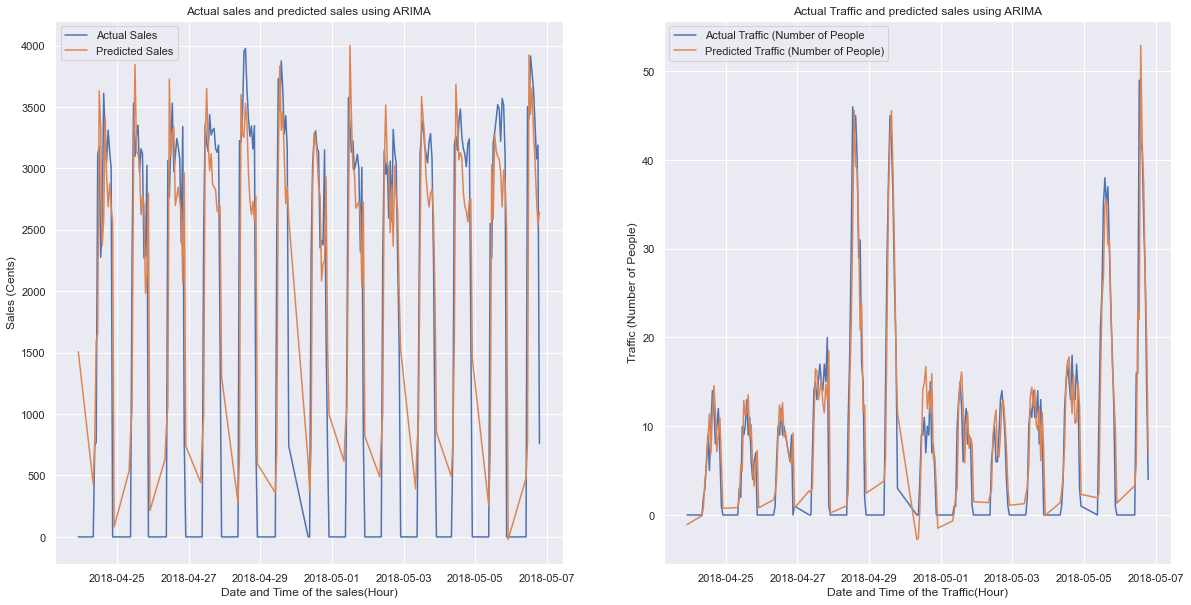

In [42]:
#Last two weeks
fig, (sales_vs_plot,traffic_vs_plot) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

#Sales
sales_vs_plot.plot(sales_mod_df[-184:], label="Actual Sales")
sales_vs_plot.plot(forecasted_sales[-184:], label="Predicted Sales")
sales_vs_plot.set_xlabel("Date and Time of the sales(Hour)")
sales_vs_plot.set_ylabel("Sales (Cents)")
sales_vs_plot.set_title("Actual sales and predicted sales using ARIMA")
sales_vs_plot.legend()

#Traffic 
traffic_vs_plot.plot(traffic_mod_df[-184:], label="Actual Traffic (Number of People")
traffic_vs_plot.plot(forecasted_traffic[-184:], label="Predicted Traffic (Number of People)")
traffic_vs_plot.set_xlabel("Date and Time of the Traffic(Hour)")
traffic_vs_plot.set_ylabel("Traffic (Number of People)")
traffic_vs_plot.set_title("Actual Traffic and predicted sales using ARIMA")
traffic_vs_plot.legend()

plt.show()

**Model Evaluation**

In [43]:
from sklearn import metrics

#Sales

sales_predicted = forecasted_sales
sales_actual = sales_mod_df["Value"]


sales_MAE = metrics.mean_absolute_error(y_true=sales_actual, y_pred=sales_predicted)
sales_RMSR= np.sqrt(metrics.mean_squared_error(y_true=sales_actual, y_pred=sales_predicted))



#Traffic

traffic_predicted = forecasted_traffic
traffic_actual = traffic_mod_df["Value"]
traffic_MAE = metrics.mean_absolute_error(y_true=traffic_actual, y_pred=traffic_predicted)
traffic_RMSR= np.sqrt(metrics.mean_squared_error(y_true=traffic_actual, y_pred=traffic_predicted))


print(f'The Mean absolute Error for store Sales ARIMA model: {sales_MAE}')
print(f'The Root Mean square Error for store Sales ARIMA model: {sales_RMSR}')

print(f'\nThe Mean absolute Error for store Traffic ARIMA model: {traffic_MAE}')
print(f'The Root Mean square Error for store Traffic ARIMA model: {traffic_RMSR}')

The Mean absolute Error for store Sales ARIMA model: 662.3915344172265
The Root Mean square Error for store Sales ARIMA model: 877.2454817497822

The Mean absolute Error for store Traffic ARIMA model: 4.467014037518258
The Root Mean square Error for store Traffic ARIMA model: 6.241722097537308


#### <Center>Forecasting sales and traffic for the following month</center>

In this problem, generating the next month's timestamps will be the first task to complete before forecasting because the intervals are not the same throughout as non-operation hours were removed for each day because the store operates at different times on weekdays and weekends. As a result, I'll repeat the procedure I used to remove the missing values in Data Preparation and Exploration.
Note: After removing these hours, the data should consist of $\approx 400$ datapoints

There are two different methods to use for this problem _Prediction_ and _Forecast_  where _Prediction_ is an in-sample forecast whereas _forecasting_ is an out-of-sample forecast.

What do I mean by that, if I wanted to focus sales or traffic for a range that lies in the given data, that would be called in-sample forecasting on the other hand if I want to forecast sales or traffic for a time period which is not in the data then that is called out-of-sampling forecast

I included 2 days from the existing data because when I am computing the inverse they will not exist because they will be Nulls

Based on the nature of the ARIMA equations, out-of-sample forecasts tend to converge to the sample mean for long forecasting periods



In [44]:
def generate_month_dates():
    #Period (Hours per month (31 days) apx  720) I set it to be large intentinally but according to this problem a month is approcimately 460, and  2 days will be removed
    times = pd.Series(pd.date_range('2018-05-04', periods=811, freq='60min')) 
    times_df = pd.DataFrame(data=times, columns=["Date"]) 


    return times_df

In [45]:
#Month new Timestamps
new_times = generate_month_dates() 

In [46]:
#Removing hours where the store doesn't open
new_times["weekday"] = new_times.Date.dt.day_name()

#Will Check for Saturday, Sunday and Monday for both dataset
sales_saturdays_times = new_times[new_times["weekday"]=="Saturday"]
sales_sundays_times = new_times[new_times["weekday"]=="Sunday"]
sales_monday_times = new_times[new_times["weekday"]=="Monday"]

#Removing the times where the store was not operating
new_times= new_times[((new_times["Date"].dt.hour<=22)&(new_times["Date"].dt.hour>=8))] #Weekdays
new_times= new_times.drop(new_times[(new_times["Date"].dt.hour==8) & (new_times["weekday"]=="Saturday")].index)#Saturday
new_times= new_times.drop(new_times[(new_times["Date"].dt.hour==8) & (new_times["weekday"]=="Sunday")].index)#Sundays
new_times= new_times.drop(new_times[(new_times["Date"].dt.hour==9) & (new_times["weekday"]=="Sunday")].index)#Sundays
new_times= new_times.drop(new_times[(new_times["Date"].dt.hour>=20) & (new_times["weekday"]=="Sunday")].index)#Sundays

#Removing the extra columns added
new_times = new_times[new_times['Date'] > '2018-05-06 17:00:00'] #Taking only two data points from the previous month to avoid nulls in the dataset of the new month after inversing

new_times.reset_index(inplace=True)
new_times.drop(columns=["weekday","index"], inplace=True)


sales_new_times=traffic_new_times=new_times

Dispalying the hours in each generated dataset

In [47]:
sales_new_times.Date.dt.hour.unique() #Hours in the dataset

array([18, 19,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22])

In [48]:
traffic_new_times.Date.dt.hour.unique() 

array([18, 19,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22])

In [49]:
new_times #Notice the first two data points (Last Points) are from the original dataset and the

,Date
0,2018-05-06 18:00:00
1,2018-05-06 19:00:00
2,2018-05-07 08:00:00
3,2018-05-07 09:00:00
4,2018-05-07 10:00:00
...,...
434,2018-06-06 14:00:00
435,2018-06-06 15:00:00
436,2018-06-06 16:00:00
437,2018-06-06 17:00:00


In [ ]:
#Sales
predicted_new_sales= pd.DataFrame(sales_model_results.forecast(439))
predicted_new_sales.reset_index(inplace=True)
predicted_new_sales.drop(columns=["index"], inplace=True)
predicated_sales_month= sales_new_times.join(predicted_new_sales)

predicated_sales_month.set_index("Date",inplace=True)


In [51]:
#Traffic
predicted_new_traffic= pd.DataFrame(traffic_model_results.forecast(439))
predicted_new_traffic.reset_index(inplace=True)
predicted_new_traffic.drop(columns=["index"], inplace=True)
predicated_traffic_month= traffic_new_times.join(predicted_new_traffic)

predicated_traffic_month.set_index("Date", inplace=True)
predicated_traffic_month=predicated_traffic_month.clip(lower=0) #setting the negative first values as they actual mean zeros because they are from previous month


/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


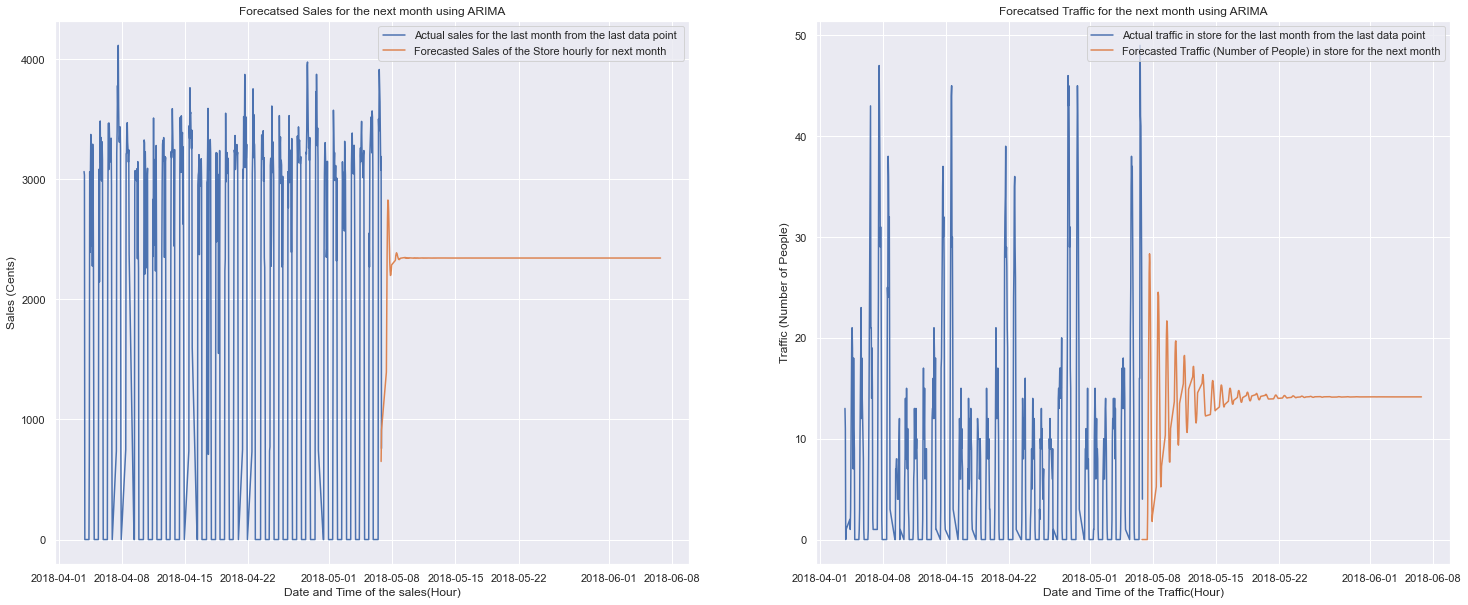

In [52]:

fig, (sales_plot,traffic_plot) = plt.subplots(ncols=2, nrows=1, figsize=(25,10))

#Sales
sales_plot.plot(sales_mod_df[-469:], label="Actual sales for the last month from the last data point ")
sales_plot.plot(predicated_sales_month, label="Forecasted Sales of the Store hourly for next month")
sales_plot.set_xlabel("Date and Time of the sales(Hour)")
sales_plot.set_ylabel("Sales (Cents)")
sales_plot.set_title("Forecatsed Sales for the next month using ARIMA")
sales_plot.legend()


#Traffic 
traffic_plot.plot(traffic_mod_df[-469:], label="Actual traffic in store for the last month from the last data point")
traffic_plot.plot(predicated_traffic_month, label="Forecasted Traffic (Number of People) in store for the next month")
traffic_plot.set_xlabel("Date and Time of the Traffic(Hour)")
traffic_plot.set_ylabel("Traffic (Number of People)")
traffic_plot.set_title("Forecatsed Traffic for the next month using ARIMA")
traffic_plot.legend()

plt.show()